<a href="https://colab.research.google.com/github/SaraSopr/DataPoweredSoftware/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup: unzip + pick sample images

In [3]:
# Setup: unzip + pick sample images
import os, zipfile, random, cv2
import numpy as np
from skimage import io, color

DATA_ZIP = "intel-image-classification (1).zip"  # put the zip next to your notebook/script
EXTRACT_DIR = "intel_image_cls"
FIG_DIR = "assignment2_figs"
os.makedirs(FIG_DIR, exist_ok=True)

# Unzip once
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(DATA_ZIP, 'r') as zf:
        zf.extractall(EXTRACT_DIR)

# Find a train-like root (seg_train or train)
def find_train_root(root):
    candidates = ["seg_train", "train", "intel-image-classification/seg_train", "seg_train/seg_train"]
    for c in candidates:
        p = os.path.join(root, c)
        if os.path.exists(p):
            return p
    for r, d, f in os.walk(root):
        for name in d:
            if name.lower().startswith("seg_train") or name.lower() == "train":
                return os.path.join(r, name)
    return None

train_root = find_train_root(EXTRACT_DIR)

# List class folders
classes = []
if train_root and os.path.isdir(train_root):
    for d in sorted(os.listdir(train_root)):
        dpath = os.path.join(train_root, d)
        if os.path.isdir(dpath):
            classes.append(dpath)

# Sample ≥3 images (from 3 classes if possible)
import glob
def sample_images_per_class(class_dirs, n_classes=3, per_class=1):
    random.seed(7)
    chosen = random.sample(class_dirs, min(n_classes, len(class_dirs))) if class_dirs else []
    images = []
    for cdir in chosen:
        files = [os.path.join(cdir, f) for f in os.listdir(cdir)
                 if f.lower().endswith((".jpg",".jpeg",".png"))]
        random.shuffle(files)
        images += files[:per_class]
    if len(images) < 3:  # fallback: grab any images
        all_imgs = glob.glob(os.path.join(EXTRACT_DIR, "**", "*.jpg"), recursive=True)
        images = (images + all_imgs)[:3]
    return images[:6]

SAMPLE_PATHS = sample_images_per_class(classes, n_classes=3, per_class=2)

# Helper: read gray + optional downscale
def read_gray(path, target_max=512):
    img = io.imread(path)
    gray = img if img.ndim == 2 else color.rgb2gray(img)
    h, w = gray.shape
    scale = min(1.0, target_max / max(h, w))
    if scale < 1.0:
        gray = cv2.resize(gray, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return gray


1) HOG (Histogram of Oriented Gradients)


[HOG] Starting...


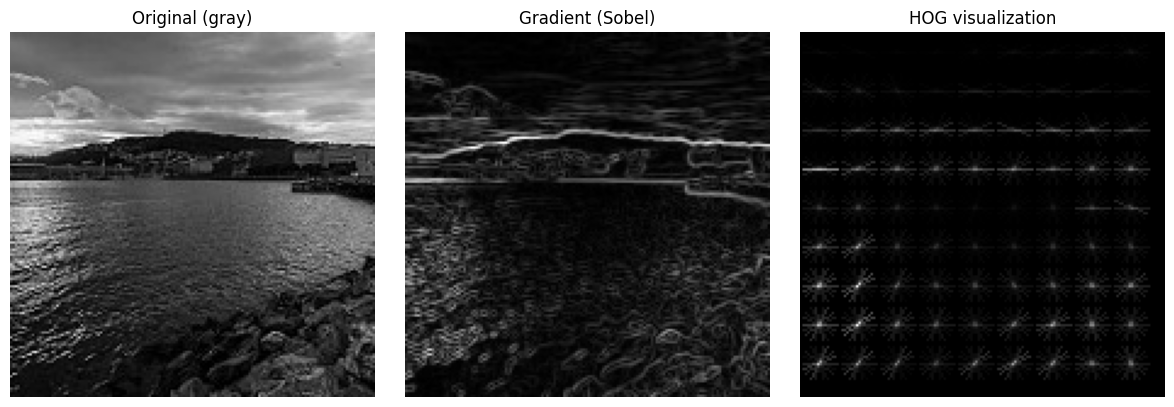

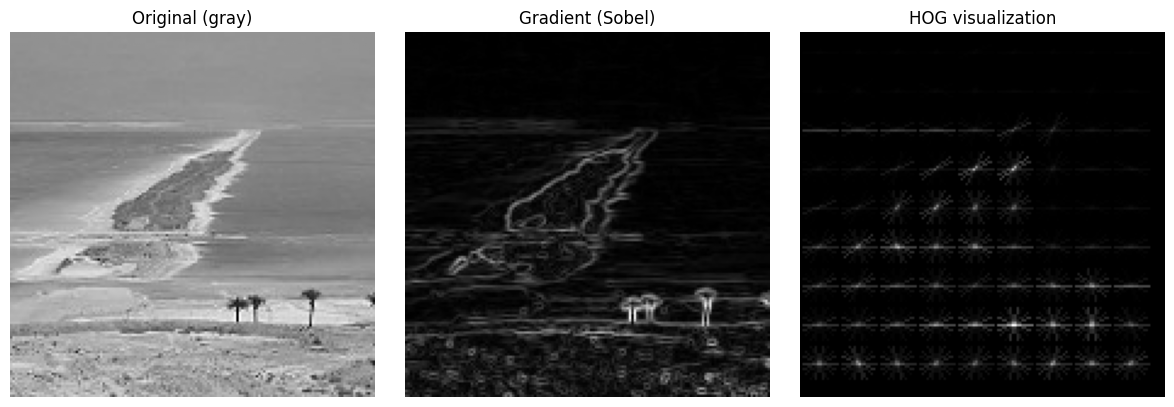

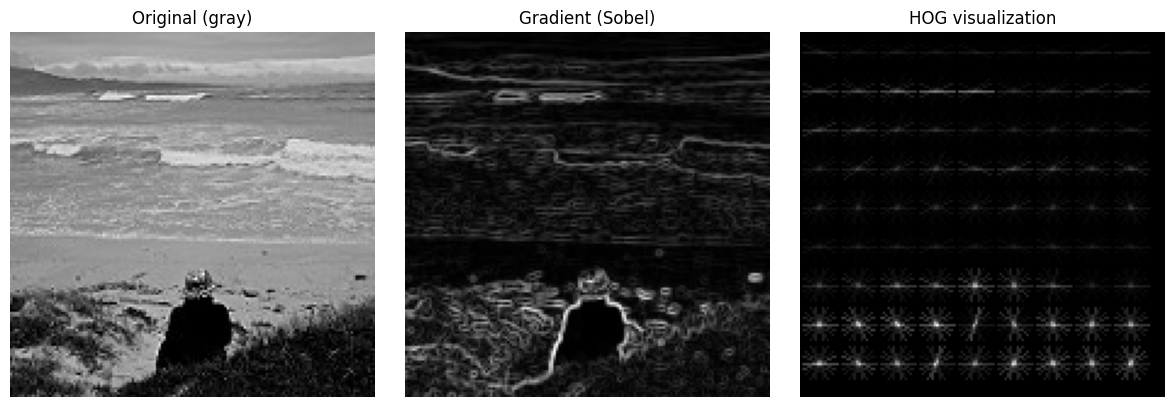

[HOG] Results (path, feature_length, fig):
  ('intel_image_cls/seg_test/seg_test/sea/24158.jpg', 2304, 'assignment2_figs/hog_0.png')
  ('intel_image_cls/seg_test/seg_test/sea/21563.jpg', 2304, 'assignment2_figs/hog_1.png')
  ('intel_image_cls/seg_test/seg_test/sea/22620.jpg', 2304, 'assignment2_figs/hog_2.png')


In [4]:
# Q1: HOG features (prints + figures saved + show) ---
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import filters, exposure

print("\n[HOG] Starting...")
hog_results = []  # (path, feature_length, saved_figure_path)

for idx, path in enumerate(SAMPLE_PATHS[:3]):  # use first 3 images
    gray = read_gray(path)
    grad = filters.sobel(gray)  # for visualization only
    fd, hog_img = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=True,
        transform_sqrt=True,
        feature_vector=True,
    )
    hog_vis = exposure.rescale_intensity(hog_img, in_range=(hog_img.min(), hog_img.max()))

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(gray, cmap="gray"); axs[0].set_title("Original (gray)"); axs[0].axis("off")
    axs[1].imshow(grad, cmap="gray"); axs[1].set_title("Gradient (Sobel)"); axs[1].axis("off")
    axs[2].imshow(hog_vis, cmap="gray"); axs[2].set_title("HOG visualization"); axs[2].axis("off")

    out_path = os.path.join(FIG_DIR, f"hog_{idx}.png")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.show()  # <-- show immediately
    hog_results.append((path, len(fd), out_path))

print("[HOG] Results (path, feature_length, fig):")
for r in hog_results:
    print(" ", r)


2) LBP (Local Binary Patterns)


[LBP] Starting...


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


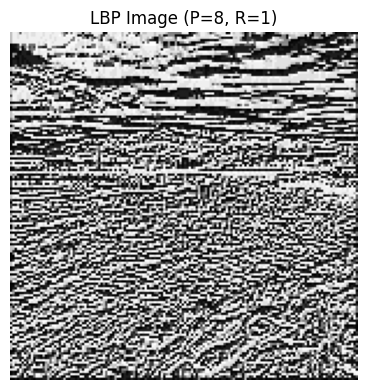

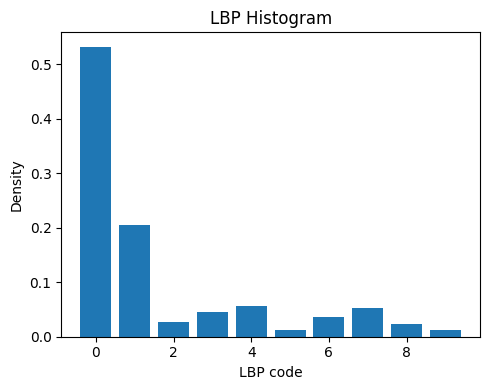

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


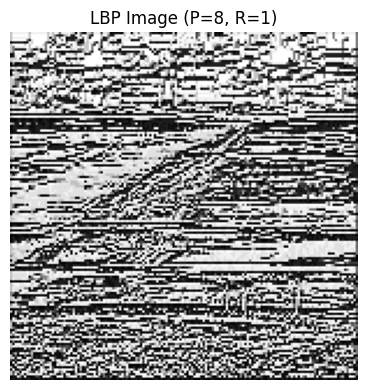

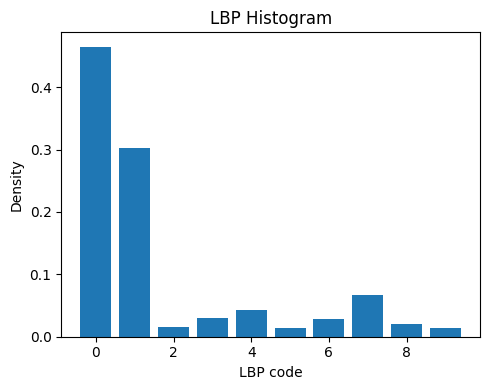

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


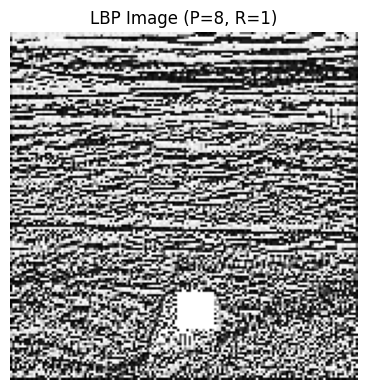

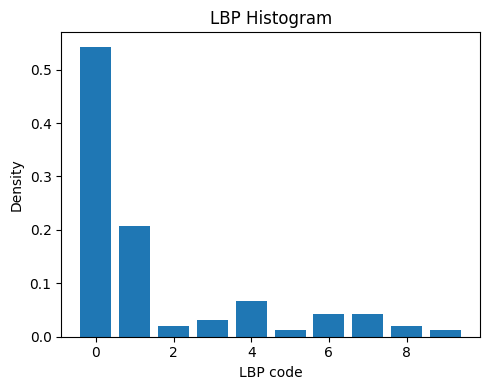

[LBP] Results (path, P, R, lbp_img_fig, lbp_hist_fig):
  ('intel_image_cls/seg_test/seg_test/sea/24158.jpg', 8, 1, 'assignment2_figs/lbp_img_0.png', 'assignment2_figs/lbp_hist_0.png')
  ('intel_image_cls/seg_test/seg_test/sea/21563.jpg', 8, 1, 'assignment2_figs/lbp_img_1.png', 'assignment2_figs/lbp_hist_1.png')
  ('intel_image_cls/seg_test/seg_test/sea/22620.jpg', 8, 1, 'assignment2_figs/lbp_img_2.png', 'assignment2_figs/lbp_hist_2.png')


In [5]:
# Q2: LBP (P=8, R=1)
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

print("\n[LBP] Starting...")
lbp_results = []  # (path, P, R, lbp_image_fig, lbp_hist_fig)
P, R = 8, 1

for idx, path in enumerate(SAMPLE_PATHS[:3]):
    gray = read_gray(path)
    lbp_img = local_binary_pattern(gray, P=P, R=R, method="default")

    # Histogram over LBP codes [0..P+1]
    hist, edges = np.histogram(lbp_img.ravel(),
                               bins=np.arange(0, P+3),
                               range=(0, P+2),
                               density=True)

    # LBP image
    fig1, ax1 = plt.subplots(figsize=(5, 4))
    ax1.imshow(lbp_img, cmap="gray"); ax1.set_title(f"LBP Image (P={P}, R={R})"); ax1.axis("off")
    out_img = os.path.join(FIG_DIR, f"lbp_img_{idx}.png")
    plt.tight_layout(); plt.savefig(out_img, dpi=150); plt.show()

    # Histogram
    fig2, ax2 = plt.subplots(figsize=(5, 4))
    ax2.bar(np.arange(len(hist)), hist, width=0.8)
    ax2.set_title("LBP Histogram"); ax2.set_xlabel("LBP code"); ax2.set_ylabel("Density")
    out_hist = os.path.join(FIG_DIR, f"lbp_hist_{idx}.png")
    plt.tight_layout(); plt.savefig(out_hist, dpi=150); plt.show()

    lbp_results.append((path, P, R, out_img, out_hist))

print("[LBP] Results (path, P, R, lbp_img_fig, lbp_hist_fig):")
for r in lbp_results:
    print(" ", r)


3) Blob Detection (LoG)


[Blob] Starting...


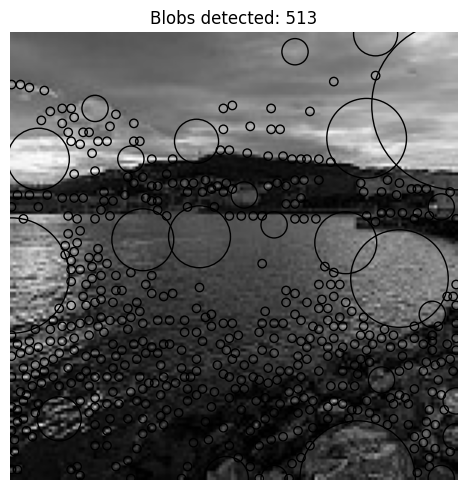

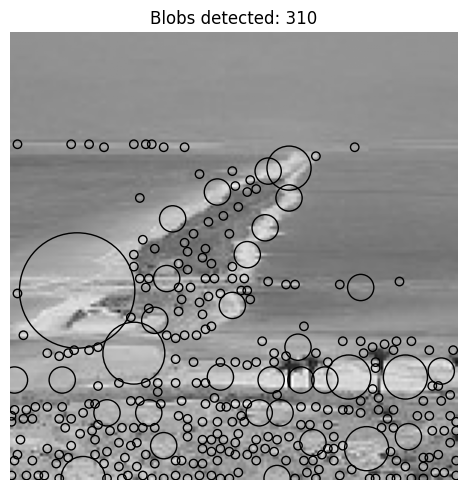

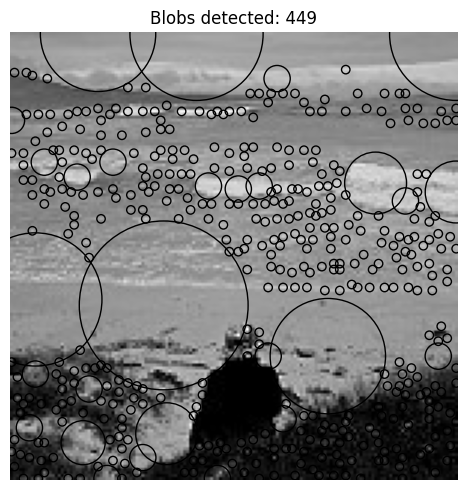

[Blob] Results (path, n_blobs, mean_radius_px, fig):
  ('intel_image_cls/seg_test/seg_test/sea/24158.jpg', 513, 1.7750417140896877, 'assignment2_figs/blob_0.png')
  ('intel_image_cls/seg_test/seg_test/sea/21563.jpg', 310, 1.8476015895519473, 'assignment2_figs/blob_1.png')
  ('intel_image_cls/seg_test/seg_test/sea/22620.jpg', 449, 1.886318015637462, 'assignment2_figs/blob_2.png')


In [6]:
# Q3: Blob detection (LoG)
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log

print("\n[Blob] Starting...")
blob_results = []  # (path, n_blobs, mean_radius_px, fig)

for idx, path in enumerate(SAMPLE_PATHS[:3]):
    gray = read_gray(path)
    blobs = blob_log(gray, min_sigma=1, max_sigma=20, num_sigma=10, threshold=0.03)  # (y, x, sigma)
    radii = blobs[:, 2] * np.sqrt(2) if blobs.size else np.array([])

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(gray, cmap="gray"); ax.set_axis_off()
    for (y, x, s), r in zip(blobs, radii):
        circ = plt.Circle((x, y), r, fill=False)
        ax.add_patch(circ)
    ax.set_title(f"Blobs detected: {len(blobs)}")

    out_blob = os.path.join(FIG_DIR, f"blob_{idx}.png")
    plt.tight_layout(); plt.savefig(out_blob, dpi=150); plt.show()

    blob_results.append((
        path,
        int(len(blobs)),
        float(np.mean(radii)) if len(radii) else 0.0,
        out_blob
    ))

print("[Blob] Results (path, n_blobs, mean_radius_px, fig):")
for r in blob_results:
    print(" ", r)



[Contours] Starting...


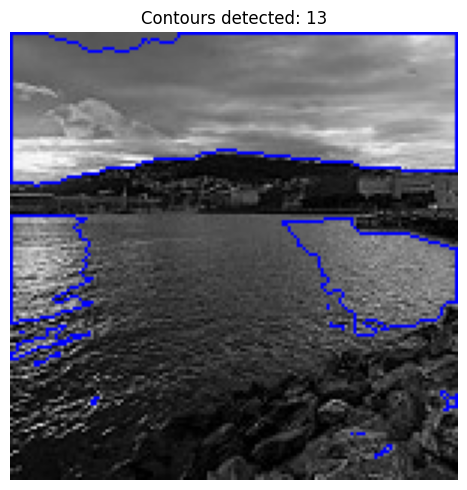

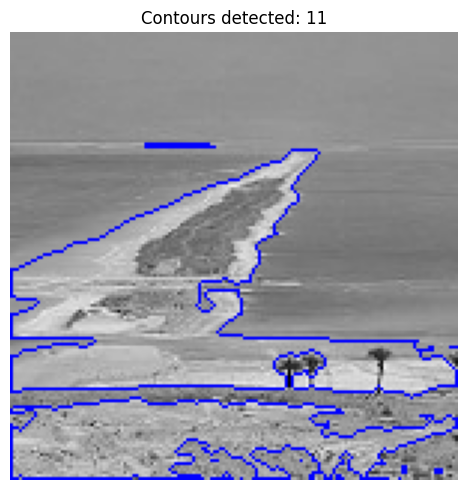

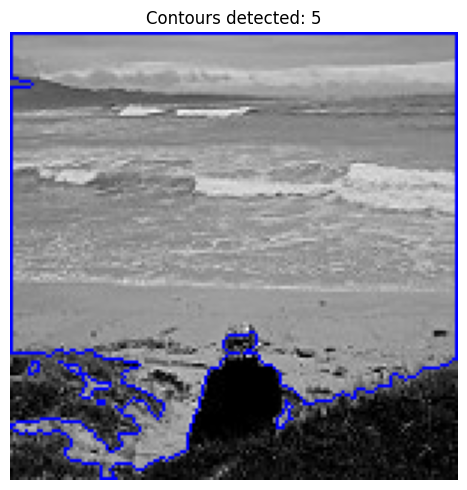

[Contours] Results (path, n_contours, mean_area, mean_perimeter, fig):
  ('intel_image_cls/seg_test/seg_test/sea/24158.jpg', 13, 665.5384615384615, 70.26505679350633, 'assignment2_figs/contours_0.png')
  ('intel_image_cls/seg_test/seg_test/sea/21563.jpg', 11, 741.5, 118.10845393484288, 'assignment2_figs/contours_1.png')
  ('intel_image_cls/seg_test/seg_test/sea/22620.jpg', 5, 3540.8, 179.4489455461502, 'assignment2_figs/contours_2.png')


In [7]:
# Q4: Contour detection
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("\n[Contours] Starting...")
contour_results = []  # (path, n_contours, mean_area, mean_perimeter, fig)

for idx, path in enumerate(SAMPLE_PATHS[:3]):
    gray = read_gray(path)
    g8 = (gray * 255).astype(np.uint8)

    # Preprocess: Gaussian blur + Otsu threshold
    blur = cv2.GaussianBlur(g8, (5, 5), 0)
    _, thr = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find external contours
    contours, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Stats
    areas  = [cv2.contourArea(c) for c in contours]
    perims = [cv2.arcLength(c, True) for c in contours]
    mean_area  = float(np.mean(areas))  if areas  else 0.0
    mean_perim = float(np.mean(perims)) if perims else 0.0

    # Visualize
    vis = cv2.cvtColor(g8, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(vis, contours, -1, (255, 0, 0), 1)

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Contours detected: {len(contours)}"); ax.axis("off")
    out_ctr = os.path.join(FIG_DIR, f"contours_{idx}.png")
    plt.tight_layout(); plt.savefig(out_ctr, dpi=150); plt.show()

    contour_results.append((path, int(len(contours)), mean_area, mean_perim, out_ctr))

print("[Contours] Results (path, n_contours, mean_area, mean_perimeter, fig):")
for r in contour_results:
    print(" ", r)
